In [126]:
from data_read import *
from odometry_functions_depthcompletion_dataset import *
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.optimize import least_squares
import os
import math
import sympy as sym
import matplotlib.pyplot as plt

In [127]:
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.2,
                       minDistance = 7,
                       blockSize = 7,
                       useHarrisDetector=False)
lk_params = dict( winSize  = (15,15),
                  maxLevel = 6,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
data_loader=Data_load(input_line=64, frames=5)
lidar_frames,gt_frames,img_frames,index_list=data_loader.read_frames(batch=1, if_removal=False)


<class 'numpy.ndarray'>
Num features :  16


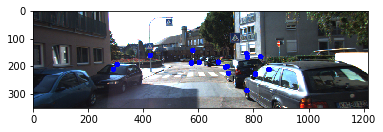

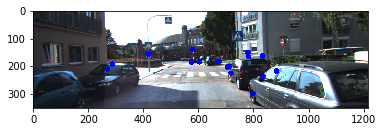

[[-6.43147977e+00 -4.48474986e+00  4.97851562e+01]
 [-4.70690046e+00 -1.89413994e+00  4.58632812e+01]
 [ 2.92277787e-01 -7.36285344e-01  2.85625000e+01]
 [-6.37364514e+00 -1.91723696e+00  4.77031250e+01]
 [-1.08684011e+00 -1.83084989e+00  4.31718750e+01]
 [ 1.15031733e+00  3.84971681e-02  9.26171875e+00]
 [ 2.89268785e-02 -2.61091882e-01  1.16289062e+01]
 [ 9.69789218e-01 -6.64575071e-01  1.06562500e+01]
 [ 2.42489038e+00 -1.85750636e-01  1.36757812e+01]
 [-1.29911466e+01 -1.00773834e+00  3.00468750e+01]
 [-4.84066654e+00 -1.58790582e-01  1.08085938e+01]
 [ 6.31267248e-01  5.10358473e-01  7.10937500e+00]
 [ 3.77015154e+00 -1.71848385e+00  2.61601562e+01]
 [ 2.49189057e+00 -2.21337548e+00  2.84179688e+01]
 [-6.22689988e+00 -1.48061682e+00  2.07851562e+01]
 [ 1.76128688e-01  9.27846289e-03  1.11718750e+01]]
Total points :  16
Solution found :  True
T (from solvePnPRansac) : 
[[ 9.99956895e-01  9.28478140e-03 -2.43304216e-06 -1.48650117e-01]
 [-9.28478118e-03  9.99956714e-01 -6.02730347e-

In [128]:
features = find_keypoints(img_frames[0,:,:,:],lidar_frames[0,:,:,0],feature_params)
print(type(features))
next_features, status, error = track_features(img_frames[0,:,:,:],features,img_frames[1,:,:,:],lk_params)
features = features[status==1]
next_features = next_features[status==1]
print("Num features : ",len(features))

image = np.copy(img_frames[0,:,:,:])
next_image = np.copy(img_frames[1,:,:,:])
for i in range(len(features)):
    cv2.circle(image,(features[i][0],features[i][1]),10,(0,0,255),-1)
    cv2.circle(next_image,(next_features[i][0],next_features[i][1]),10,(0,0,255),-1)

plt.imshow(image)
plt.show()

plt.imshow(next_image)
plt.show()

scene=data_loader.img_path[index_list[0]].split('/')[5].split('_')[:3]
scene_date = scene[0]
camera_id = data_loader.img_path[index_list[0]].split('/')[-3]
for i in range(1,len(scene)) : 
    scene_date += '_' + scene[i]
K = get_calib_file(scene_date,camera_id) # eg: 2011_09_26, image_03
pts_3d_1 = compute_3D_points(lidar_frames[0,:,:,:],features,K)

print(pts_3d_1)

pts_2d_2 = []
for i in range(len(features)):
    x = int(next_features[i,0])
    y = int(next_features[i,1])
    pts_2d_2.append([x,y])
pts_2d_2 = np.asarray(pts_2d_2)
# print(pts_3d_1)
print("Total points : ",len(pts_2d_2))
# print(pts_2d_2)
P = np.hstack((K,np.zeros((3,1))))

pts_3d_1 = np.expand_dims(pts_3d_1.astype(np.float32),axis=1)
pts_2d_2 = np.expand_dims(pts_2d_2.astype(np.float32),axis=1)
ret = cv2.solvePnPRansac(pts_3d_1,pts_2d_2,P[:3,:3],distCoeffs=None)

print("Solution found : ",ret[0])

r = genEulerZXZMatrix(-ret[1][0][0],-ret[1][1][0],-ret[1][2][0])
transf_matrix = np.hstack((r,-ret[2]))
transf_matrix = np.vstack((transf_matrix,np.asarray([0,0,0,1])))
print("T (from solvePnPRansac) : ")
print(transf_matrix)

In [129]:
pts_3d_1 = np.hstack( (np.squeeze(pts_3d_1), np.ones(( len(pts_3d_1),1) )))
pts_2d_2 = np.hstack( (np.squeeze(pts_2d_2), np.ones(( len(pts_2d_2),1) )))


dSeed = np.zeros(len(pts_3d_1))
opt = least_squares(func,dSeed,method='lm',verbose=0,args=(pts_3d_1,pts_2d_2,P))
R = genEulerZXZMatrix(opt.x[0],opt.x[1],opt.x[2])
t = np.asarray([[opt.x[3]],[opt.x[4]],[opt.x[5]]])
T = np.hstack((R,t))
T = np.vstack((T,np.asarray([[0,0,0,1]])))
print("T (from scipy least_squares) : ")
print(T)

T (from scipy least_squares) : 
[[ 9.99998686e-01  1.62123500e-03 -1.41522770e-06 -9.42943846e-02]
 [-1.62122463e-03  9.99994742e-01  2.80849587e-03 -4.78858824e-02]
 [ 5.96845204e-06 -2.80848988e-03  9.99996056e-01  8.20180499e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


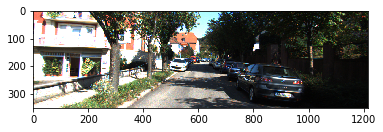

In [123]:
plt.imshow(img_frames[0,:,:])
plt.show()

## Using ground truth as the Lidar image input

<class 'numpy.ndarray'>
Num features :  8


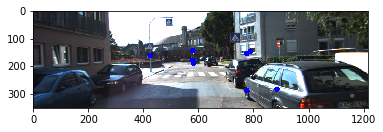

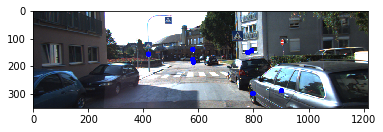

[[-7.11335152 -2.27142028 56.515625  ]
 [-6.43147977 -4.48474986 49.78515625]
 [ 2.81494065 -2.39256776 27.578125  ]
 [ 0.91940095  0.28598136  4.390625  ]
 [-7.28783294 -2.8927955  56.4140625 ]
 [ 0.63126725  0.51035847  7.109375  ]
 [ 2.49189057 -2.21337548 28.41796875]
 [-6.22689988 -1.48061682 20.78515625]]
Total points :  8
Solution found :  True
T (from solvePnPRansac) : 
[[ 9.99992503e-01 -3.87222634e-03  6.76082738e-07 -8.72824900e-02]
 [ 3.87222640e-03  9.99992485e-01 -1.90834741e-04 -4.15701517e-02]
 [ 6.28776527e-08  1.90835928e-04  9.99999982e-01  7.50353294e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [130]:
features = find_keypoints(img_frames[0,:,:,:],gt_frames[0,:,:,0],feature_params)
print(type(features))
next_features, status, error = track_features(img_frames[0,:,:,:],features,img_frames[1,:,:,:],lk_params)
features = features[status==1]
next_features = next_features[status==1]
print("Num features : ",len(features))

image = np.copy(img_frames[0,:,:,:])
next_image = np.copy(img_frames[1,:,:,:])
for i in range(len(features)):
    cv2.circle(image,(features[i][0],features[i][1]),10,(0,0,255),-1)
    cv2.circle(next_image,(next_features[i][0],next_features[i][1]),10,(0,0,255),-1)

plt.imshow(image)
plt.show()

plt.imshow(next_image)
plt.show()

scene=data_loader.img_path[index_list[0]].split('/')[5].split('_')[:3]
scene_date = scene[0]
camera_id = data_loader.img_path[index_list[0]].split('/')[-3]
for i in range(1,len(scene)) : 
    scene_date += '_' + scene[i]
K = get_calib_file(scene_date,camera_id) # eg: 2011_09_26, image_03
pts_3d_1 = compute_3D_points(gt_frames[0,:,:,:],features,K)

print(pts_3d_1)

pts_2d_2 = []
for i in range(len(features)):
    x = int(next_features[i,0])
    y = int(next_features[i,1])
    pts_2d_2.append([x,y])
pts_2d_2 = np.asarray(pts_2d_2)
# print(pts_3d_1)
print("Total points : ",len(pts_2d_2))
# print(pts_2d_2)
P = np.hstack((K,np.zeros((3,1))))

pts_3d_1 = np.expand_dims(pts_3d_1.astype(np.float32),axis=1)
pts_2d_2 = np.expand_dims(pts_2d_2.astype(np.float32),axis=1)
ret = cv2.solvePnPRansac(pts_3d_1,pts_2d_2,P[:3,:3],distCoeffs=None)

print("Solution found : ",ret[0])

r = genEulerZXZMatrix(ret[1][0][0],ret[1][1][0],ret[1][2][0])
transf_matrix = np.hstack((r,-ret[2]))
transf_matrix = np.vstack((transf_matrix,np.asarray([0,0,0,1])))
print("T (from solvePnPRansac) : ")
print(transf_matrix)

In [132]:
pts_3d_1 = np.hstack( (np.squeeze(pts_3d_1), np.ones(( len(pts_3d_1),1) )))
pts_2d_2 = np.hstack( (np.squeeze(pts_2d_2), np.ones(( len(pts_2d_2),1) )))


dSeed = np.zeros(len(pts_3d_1))
opt = least_squares(func,dSeed,method='lm',verbose=0,args=(pts_3d_1,pts_2d_2,P))
R = genEulerZXZMatrix(opt.x[0],opt.x[1],opt.x[2])
t = np.asarray([[opt.x[3]],[opt.x[4]],[opt.x[5]]])
T = np.hstack((R,t))
T = np.vstack((T,np.asarray([[0,0,0,1]])))
print("T (from scipy least_squares) : ")
print(T)

ValueError: shapes (3,4) and (5,) not aligned: 4 (dim 1) != 5 (dim 0)

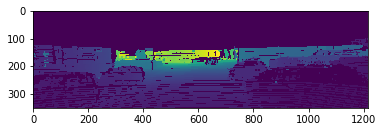

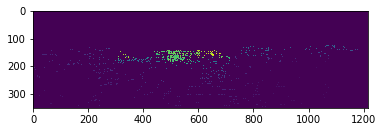

0.16451078697992513
0.7800609199317867
0.7870573182657971


In [133]:
gt = gt_frames[0,:,:,0]
depth = lidar_frames[0,:,:,0]

depth_dilated = cv2.dilate(lidar_frames[0,:,:,:],np.ones((5,5),np.uint8))
plt.imshow(depth_dilated)
plt.show()
plt.imshow(gt_frames[0,:,:,0])
plt.show()

gt_mask = np.where(gt!=0,1,0)
depth_mask = np.where(depth!=0,1,0)
dDepth_mask = np.where(depth_dilated!=0,1,0)

diff_gt_depth = gt_mask * depth_mask * (gt - depth)
diff_gt_depth *= diff_gt_depth
print(np.sqrt(np.mean(diff_gt_depth)))

diff_gt_dDepth = gt_mask * dDepth_mask * (gt - depth_dilated)
diff_gt_dDepth *= diff_gt_dDepth
print(np.sqrt(np.mean(diff_gt_dDepth)))

diff_depth_dDepth = depth_mask * dDepth_mask * (depth - depth_dilated)
diff_depth_dDepth *= diff_depth_dDepth
print(np.sqrt(np.mean(diff_depth_dDepth)))

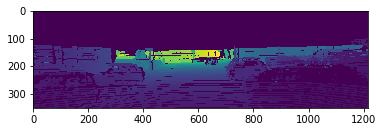

0.16451078697992513
0.5369018109488476
0.7631901216822894


In [134]:
depth_inverted = np.where(depth>0,100-depth,0)

depth_dilated = cv2.dilate(depth_inverted,np.ones((5,5),np.uint8))

depth_dilated = np.where(depth_dilated>0,100-depth_dilated,0)
plt.imshow(depth_dilated)
plt.show()

gt_mask = np.where(gt!=0,1,0)
depth_mask = np.where(depth!=0,1,0)
dDepth_mask = np.where(depth_dilated!=0,1,0)

diff_gt_depth = gt_mask * depth_mask * (gt - depth)
diff_gt_depth *= diff_gt_depth
print(np.sqrt(np.mean(diff_gt_depth)))

diff_gt_dDepth = gt_mask * dDepth_mask * (gt - depth_dilated)
diff_gt_dDepth *= diff_gt_dDepth
print(np.sqrt(np.mean(diff_gt_dDepth)))

diff_depth_dDepth = depth_mask * dDepth_mask * (depth - depth_dilated)
diff_depth_dDepth *= diff_depth_dDepth
print(np.sqrt(np.mean(diff_depth_dDepth)))
